In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib notebook
import os
import sys
import pickle
from struct import *
import pandas as pd
from sklearn.model_selection import train_test_split
#import data_utils
from IPython.display import clear_output
import seaborn as sns
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")
import plotting
from plotting import *
from scipy.stats import norm, pearsonr
from scipy.signal import argrelextrema
from statistics import median

## Load the data

In [3]:
# Upload the error data
#errors = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/tagged_errors.csv', index_col=[0])
errors_ = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/error-tags_full.csv', index_col=[0])

errors_.loc[:, 'subID':'Track'] = errors_.loc[:, 'subID':'Track'].astype(str)
#errors.loc[:, 'Timestamp':'value5b'] = errors.loc[:, 'Timestamp':'value5b'].astype(float)
errors_.loc[:, 'HMD'] = errors_.loc[:, 'HMD'].astype(str)
errors_.loc[:, 'offset'] = errors_.loc[:, 'offset'].astype(bool)
#errors.loc[:, 'Timestamp_adjusted'] = errors.loc[:, 'Timestamp_adjusted'].astype(float)

# filter to motor errors
errors_['motor_error'] = False
for idx, row in errors_.iterrows():
    if row.error_type_value1=='1' or row.error_type_value2=='1' or row.error_type_value3=='1' or row.error_type_value4=='1' or row.error_type_value5=='1':
        errors_.loc[idx, 'motor_error'] = True
    
errors_ = errors_[errors_.motor_error==True]

errors_.reset_index(drop=True, inplace=True)

assert all(errors_['offset'] == True), "The timestamps of tagged errors have not been adjusted."

In [4]:
errors_.head()

,subID,task,Video,Track,Timestamp,errors_in_frame,time_to_prev_error,time_to_next_error,value1,error_type_value1,...,error_subtype_value4,value4b,value5,error_type_value5,error_subtype_value5,value5b,HMD,offset,Timestamp_adjusted,motor_error
0,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,7.84,2,,-4,31,2,...,,,,,,,varjo,True,8.403196,True
1,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,11.84,1,4,-7.52,13,1,...,,,,,,,varjo,True,12.403196,True
2,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,19.36,2,7.52,-5.64,13,1,...,,,,,,,varjo,True,19.923196,True
3,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,25.00,2,5.64,-7.36,6,1,...,,,,,,,varjo,True,25.563196,True
4,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,32.36,1,7.36,-1.12,1,1,...,,,,,,,varjo,True,32.923196,True


In [5]:
# Read in the output data from event detection
seq = pd.read_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/all_sequences_varjo.csv')
del seq['Unnamed: 0']

In [6]:
seq.head()

,HMD,rate,eye,task,subID,VL,event,start_i,end_i,start_s,...,calculus_error,carpenter_error,P_nonfix,P_fix,P_ff,P_smp,P_sac,P_blink,has_blink,UID
0,varjo,200,right,cereal,P19,CVL,smp,0,25,1.081565,...,0.366132,1.527210,0.534494,0.465506,5.470863e-11,0.465506,0.384207,0.150287,0,varjoP19cerealright
1,varjo,200,right,cereal,P19,CVL,fix,26,49,1.211610,...,0.230767,2.684010,0.059622,0.940378,8.531830e-01,0.087195,0.057516,0.002106,0,varjoP19cerealright
2,varjo,200,right,cereal,P19,CVL,sac,50,56,1.326648,...,0.732365,0.474248,0.728794,0.271206,2.022088e-01,0.068997,0.000396,0.728398,0,varjoP19cerealright
3,varjo,200,right,cereal,P19,CVL,noise,57,59,1.361658,...,NaN,NaN,0.667140,0.332860,3.218246e-01,0.011035,0.000000,0.000000,0,varjoP19cerealright
4,varjo,200,right,cereal,P19,CVL,fix,60,205,1.381670,...,0.913183,24.923594,NaN,NaN,NaN,NaN,NaN,NaN,0,varjoP19cerealright


In [7]:
# upload the experiment start and end times
offsets = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/offsets.csv', index_col=[0])
offsets.head()

,HMD,subID,task,exper_start(s),exper_end(s)
0,varjo,P14,cereal,2.262060,175.435060
1,varjo,P14,sandwich,-0.044110,502.057489
2,varjo,P23,cereal,0.794094,189.215660
3,varjo,P23,sandwich,1.659792,948.839357
4,varjo,P19,cereal,2.963828,137.798528


In [8]:
# upload the differences between gaze data and videos
gaze_dur_diff = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/gaze_dur_diff.csv', index_col=[0])
gaze_dur_diff.head()

,HMD,task,subID,type,lum_path,dur(s),min_lum_roc,min_lum_frame,min_lum_time(s),data_dur(s),diff(s)
0,varjo,cereal,P14,full,/data/AMPs/second-round/avg-lum-per-frame/P14_...,172.733166,-0.621721,206.0,6.866660,172.757628,-0.024462
2,varjo,cereal,P23,full,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.033152,-0.459796,201.0,6.699994,188.056043,-0.022891
4,varjo,cereal,P19,full,/data/AMPs/second-round/avg-lum-per-frame/P19_...,137.433200,-0.376091,174.0,5.799994,137.429682,0.003519
6,varjo,cereal,P2,full,/data/AMPs/second-round/avg-lum-per-frame/P2_c...,121.699882,-0.389706,193.0,6.433327,121.715036,-0.015154
8,varjo,cereal,P9,full,/data/AMPs/second-round/avg-lum-per-frame/P9_c...,123.899880,-0.535024,210.0,6.999993,123.907213,-0.007332


## Evaluate at what frequency motor errors are occuring in the datasets

In [9]:
%matplotlib inline

In [10]:
freq_errs = pd.DataFrame({})
for subID in errors_.subID.unique():
    for task in errors_[errors_.subID==subID].task.unique():
        # calculate frequency of motor errors
        num_err = len(errors_.loc[(errors_.subID==subID)&(errors_.task==task)])
        dur = gaze_dur_diff.loc[(gaze_dur_diff.subID==subID)&(gaze_dur_diff.task==task), 'dur(s)']
        rate = dur/num_err
        freq = num_err/dur
        # log it for each participant and task
        freq_errs = pd.concat([freq_errs, pd.DataFrame({'subID':subID,'task':task,'err_rate':rate,'freq_err':freq})])

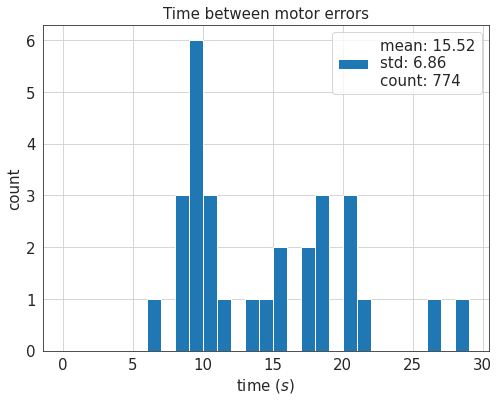

In [11]:
# show distribution of time between motor errors
mean = np.round(freq_errs.err_rate.mean(),2) 
count = len(errors_)
std = np.round(freq_errs.err_rate.std(),2) 
plt.figure(figsize=(8,6))
freq_errs.err_rate.hist(bins=range(0,30),label=f'mean: {mean}\nstd: {std}\ncount: {count}')
plt.legend(fontsize=15)
plt.title('Time between motor errors',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('count',fontsize=15)
plt.xlabel(r'time $(s)$',fontsize=15)
plt.show()

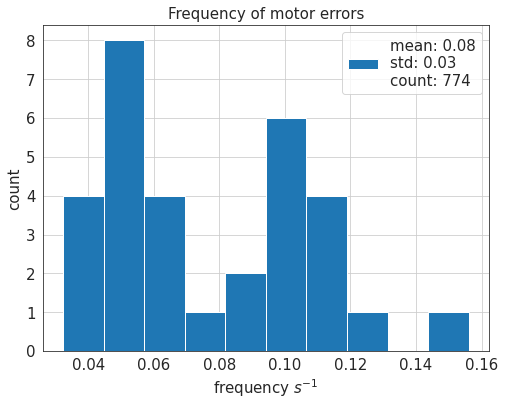

In [12]:
# show distribution of motor error frequency per dataset
mean = np.round(freq_errs.freq_err.mean(),2) 
count = len(errors_)
std = np.round(freq_errs.freq_err.std(),2) 
plt.figure(figsize=(8,6))
freq_errs.freq_err.hist(label=f'mean: {mean}\nstd: {std}\ncount: {count}')
plt.legend(fontsize=15)
plt.title('Frequency of motor errors',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('count',fontsize=15)
plt.xlabel(r'frequency $s^{-1}$',fontsize=15)
plt.show()

## Analyze events during motor errors (vs outside of motor errors)

In [13]:
# flag events falling between [-2, +5] seconds of motor errors in each dataset
seq['motor_error'] = False
success = []
failed = []
error_seq = pd.DataFrame({})
for subID in seq.subID.unique():
    
    # get corresponding error tags
    errors = errors_[errors_.subID==subID]
    errors.reset_index(drop=True, inplace=True)
    
    for eye in seq[seq.subID==subID].eye.unique():
    
        for task in seq.loc[(seq.subID==subID)&(seq.eye==eye)].task.unique():
        
            # Only continue if there are labelled errors
            try:
                exper_start = offsets.loc[(offsets.subID==subID) & (offsets.task==task), 'exper_start(s)'].values[0]
                exper_end = offsets.loc[(offsets.subID==subID) & (offsets.task==task), 'exper_end(s)'].values[0]
                dur_diff = np.abs(gaze_dur_diff.loc[(gaze_dur_diff.subID==subID) & (gaze_dur_diff.task==task), 'diff(s)']).values[0]
            except:
                failed.append('varjo'+subID+task+eye)
                continue
            
            # access error timestamps
            error_t = errors[errors.task==task].Timestamp_adjusted.to_numpy()
            
            if len(error_t) == 0:
                failed.append('varjo'+subID+task+eye)
                continue
            
            # filter gaze data and clip to experiment time
            temp = seq.loc[((seq.subID==subID)&(seq.eye==eye)&(seq.task==task))]
            temp.reset_index(drop=True, inplace=True)
            temp = temp.loc[(temp.start_s >= exper_start)&(temp.end_s<= exper_end)]
            temp.reset_index(drop=True, inplace=True)

            # flag events that fall within [-1 : +2] seconds of a motor error
            # use the absolute value of duration difference between gaze video and gaze data 
            # as uncertainties in error timestamp
            for idx, row in temp.iterrows():
                has_error = np.any([(e >= row.start_s-3-dur_diff and e <= row.end_s+2+dur_diff) for e in error_t])
                temp.loc[idx,'motor_error'] = has_error
            
            error_seq = pd.concat([error_seq, temp])
            success.append('varjo'+subID+task+eye)

print(f'Number successful datasets: {len(success)}\nNumber failed datasets: {len(failed)}')

Number successful datasets: 55
Number failed datasets: 0


In [14]:
seq = error_seq.copy()

## Evaluate changes in event feature in and out of motor errors
### -> In events during motor errors, we expect shorter saccade amplitudes and durations due to an increase in catch-up saccades, shorter smooth pursuit 


In [15]:
# evaluate the change in saccade features around errors vs not
motor = seq.loc[(seq.motor_error==True)]
no_motor = seq.loc[(seq.motor_error==False)]

# OR just report on mean - lower or higher?
print('motor')
motor.loc[(motor.event!='loss')&(motor.event!='noise')&(motor.event!='blink'),['event','amplitude','duration']].groupby('event').describe()

motor


amplitude                                                                \
          count       mean       std       min       25%       50%        75%   
event                                                                           
fix      5651.0   4.689806  4.725702  0.000000  1.815543  3.437318   5.918643   
sac      3403.0   7.597289  6.742080  1.502206  3.211181  5.518985   9.591056   
smp      2880.0  10.501899  7.733305  1.511820  5.325528  8.369728  13.269425   

                 duration                                                    \
             max    count      mean       std       min       25%       50%   
event                                                                         
fix    57.750957   5651.0  0.707236  0.922109  0.100011  0.190074  0.395129   
sac    60.555650   3403.0  0.050306  0.074566  0.009988  0.015009  0.030011   
smp    66.187136   2880.0  0.533890  0.505098  0.060017  0.230079  0.390131   

                            
            75%        max  
event                       
fix    0.835300  12.744430  
sac    0.060019   1.440492  
smp    0.665201   6.897418

In [16]:
print('no motor')
no_motor.loc[(no_motor.event!='noise')&(no_motor.event!='loss')&(no_motor.event!='blink'),['event','amplitude','duration']].groupby('event').describe()

no motor


amplitude                                                                \
          count       mean       std       min       25%       50%        75%   
event                                                                           
fix     12838.0   4.389667  4.372961  0.000000  1.685842  3.118901   5.520221   
sac      8657.0   7.981539  7.191380  1.501659  3.322711  5.877721   9.981374   
smp      6659.0  10.398660  7.605901  1.500833  5.429535  8.308063  12.987722   

                 duration                                                    \
             max    count      mean       std       min       25%       50%   
event                                                                         
fix    58.096543  12838.0  0.542289  0.647698  0.100009  0.175057  0.320129   
sac    88.633195   8657.0  0.051308  0.075094  0.009986  0.019999  0.035000   
smp    78.486784   6659.0  0.499182  0.430587  0.060013  0.215067  0.370102   

                            
            75%        max  
event                       
fix    0.655227  11.294017  
sac    0.060051   3.021076  
smp    0.635181   6.752333

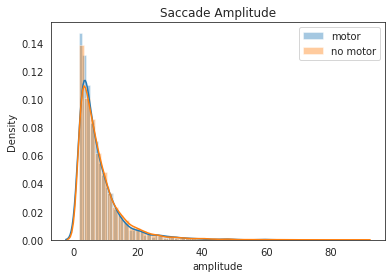

In [17]:
# visualize the change
fs = 15
plt.figure()
temp = motor.loc[motor.event=='sac'].amplitude
# label = f'mean={np.round(np.average(temp),2)}\nstd={np.round(np.std(temp),2)}\nstd={np.round(median(temp),2)}\nN={len(temp)}')
sns.distplot(temp, bins = 50, label = 'motor')
temp = no_motor.loc[no_motor.event=='sac'].amplitude
# label = f'mean={np.round(np.average(temp),2)}\nstd={np.round(np.std(temp),2)}\nstd={np.round(median(temp),2)}\nN={len(temp)}')
sns.distplot(temp, bins = 50, label = 'no motor')
plt.legend()
plt.title('Saccade Amplitude')
plt.show()


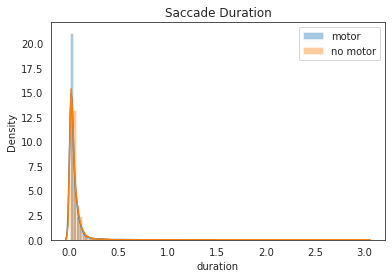

In [18]:
# visualize the change
fs = 15
plt.figure()
temp = motor.loc[motor.event=='sac'].duration
# label = f'mean={np.round(np.average(temp),2)}\nstd={np.round(np.std(temp),2)}\nstd={np.round(median(temp),2)}\nN={len(temp)}')
sns.distplot(temp, bins = 50, label = 'motor')
temp = no_motor.loc[no_motor.event=='sac'].duration
# label = f'mean={np.round(np.average(temp),2)}\nstd={np.round(np.std(temp),2)}\nstd={np.round(median(temp),2)}\nN={len(temp)}')
sns.distplot(temp, bins = 50, label = 'no motor')
plt.legend()
plt.title('Saccade Duration')
plt.show()

In [19]:
# show average

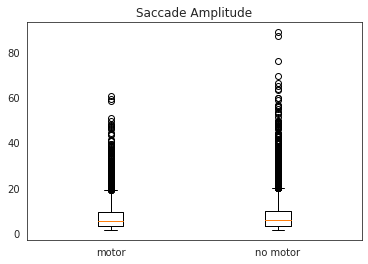

In [20]:
# visualize the change
fs = 15
plt.figure()
temp = [motor.loc[motor.event=='sac'].amplitude, no_motor.loc[no_motor.event=='sac'].amplitude]
# label = f'mean={np.round(np.average(temp),2)}\nstd={np.round(np.std(temp),2)}\nstd={np.round(median(temp),2)}\nN={len(temp)}')
plt.boxplot(temp, labels= ['motor','no motor'])
plt.title('Saccade Amplitude')
plt.show()

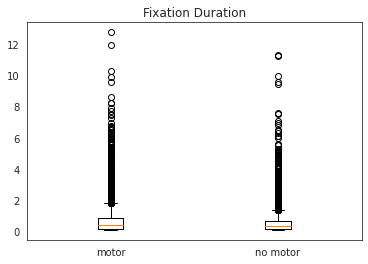

In [21]:
# visualize the change
fs = 15
plt.figure()
temp = [motor.loc[motor.event=='fix'].duration, no_motor.loc[no_motor.event=='fix'].duration]
# label = f'mean={np.round(np.average(temp),2)}\nstd={np.round(np.std(temp),2)}\nstd={np.round(median(temp),2)}\nN={len(temp)}')
plt.boxplot(temp, labels= ['motor','no motor'])
plt.title('Fixation Duration')
plt.show()

In [22]:
# # for each dataset, separate motor error eye movement events from no-motor error
# data = {}
# for UID in seq.UID.unique():
#     data[UID] = {'motor_error':seq.loc[(seq.UID==UID)&(seq.motor_error==True)],
#                  'no_motor_error':seq.loc[(seq.UID==UID)&(seq.motor_error==False)]}
# print(len(data))

In [82]:
# frequencies of eye movements by motor/no_motor
for v in [1, 0]:
    if v == 1:
        print('Motor Error')
    else:
        print('\nNon-Motor Error')
    for e in ['fix','smp','sac','blink','loss','noise']:
        temp = seq.loc[seq.motor_error==v]
        if e == 'blink':
            f = np.round((sum(temp.has_blink)+len(temp[temp.event=='blink']))/sum(temp.duration),3)
        else:
            f = np.round(len(temp[temp.event==e])/sum(temp.duration),3)

        print(f"{e}: Frequency = {f} s-1")

Motor Error
fix: Frequency = 0.905 s-1
smp: Frequency = 0.461 s-1
sac: Frequency = 0.545 s-1
blink: Frequency = 0.215 s-1
loss: Frequency = 0.0 s-1
noise: Frequency = 0.305 s-1

Non-Motor Error
fix: Frequency = 1.075 s-1
smp: Frequency = 0.558 s-1
sac: Frequency = 0.725 s-1
blink: Frequency = 0.248 s-1
loss: Frequency = 0.001 s-1
noise: Frequency = 0.389 s-1


In [47]:
# behavior of features during motor errors no normal
feats = ['event','duration','amplitude','dispersion','avg_iss','max_iss','carpenter_error','calculus_error']
err_d = seq.loc[seq.motor_error==1,feats].groupby('event').describe().T
no_err_d = seq.loc[seq.motor_error==0,feats].groupby('event').describe().T

In [80]:
states = ['fix','smp','sac','blink']
percent_change = pd.DataFrame(index=states,columns=feats[1:])
for state in states:
    for feat in feats[1:]:
        v1 = no_err_d[state][feat]['mean']
        v2 = err_d[state][feat]['mean']
        change = (v2-v1)/v1
        percent_change.loc[state,feat] = np.round(change*100,2)

In [81]:
percent_change

,duration,amplitude,dispersion,avg_iss,max_iss,carpenter_error,calculus_error
fix,30.42,6.84,6.68,2.45,7.4,29.52,3.55
smp,6.95,0.99,0.02,-3.84,-3.6,8.27,0.12
sac,-1.95,-4.81,-6.85,0.24,-1.86,3.05,0.23
blink,3.84,-4.76,-1.63,1.52,-2.3,3.96,1.91


In [51]:
pd.concat([err_d, no_err_d],axis=1)

event                       blink          fix        loss        noise  \
duration        count  768.000000  5651.000000    2.000000  1904.000000   
                mean     0.350625     0.707236    1.025341     0.139259   
                std      0.363911     0.922109    0.827569     0.204360   
                min      0.009995     0.100011    0.440161     0.009994   
                25%      0.115041     0.190074    0.732751     0.030012   
                50%      0.225056     0.395129    1.025341     0.070021   
                75%      0.460148     0.835300    1.317930     0.165052   
                max      2.686035    12.744430    1.610520     2.555881   
amplitude       count  768.000000  5651.000000    2.000000   611.000000   
                mean    10.858090     4.689806    8.394378    12.511566   
                std      9.658321     4.725702    1.438863    11.381406   
                min      0.101222     0.000000    7.376949     0.031671   
                25%      3.988418     1.815543    7.885663     4.250179   
                50%      7.488670     3.437318    8.394378     8.878616   
                75%     14.361742     5.918643    8.903093    17.764769   
                max     73.778490    57.750957    9.411807    82.061193   
dispersion      count  768.000000  5651.000000    2.000000  1904.000000   
                mean     7.476667     2.613000    4.413457     5.389866   
                std      5.752448     2.496337    0.776622     5.866199   
                min      0.544400     0.000000    3.864302     0.000000   
                25%      3.060219     1.166766    4.138880     1.642686   
                50%      5.724465     1.897683    4.413457     3.320409   
                75%     10.187301     3.134696    4.688034     6.794512   
                max     36.953628    37.361260    4.962612    55.513911   
avg_iss         count  760.000000  5647.000000    1.000000  1899.000000   
                mean   235.023918    54.121756   78.794611   202.804803   
                std    113.533877    33.923897         NaN   117.788637   
                min     74.998335     5.541926   78.794611     5.477144   
                25%    161.132412    31.047598   78.794611   112.341228   
                50%    198.753749    45.133279   78.794611   187.198718   
                75%    279.161011    67.924686   78.794611   275.699646   
                max    786.250402   355.404618   78.794611   702.051933   
max_iss         count  760.000000  5647.000000    1.000000  1899.000000   
                mean   627.228269   338.631908  124.438220   458.089863   
                std    158.439955   228.911073         NaN   243.027394   
                min    181.870254    29.592077  124.438220     5.771324   
                25%    538.543420   147.533754  124.438220   243.065527   
                50%    677.176890   260.030979  124.438220   496.097380   
                75%    754.920381   527.759478  124.438220   685.657977   
                max    799.938948   799.994836  124.438220   799.963801   
carpenter_error count  768.000000  5651.000000    2.000000   611.000000   
                mean     7.033934    21.263243   25.906704     5.566994   
                std      8.040144    28.771354   23.126340     6.639446   
                min      0.004095     1.250568    9.553912     0.001915   
                25%      2.110428     5.899149   17.730308     1.444684   
                50%      4.166525    11.831892   25.906704     3.221741   
                75%      9.165205    24.687915   34.083100     7.198791   
                max     74.379889   450.815763   42.259496    57.677138   
calculus_error  count  768.000000  5651.000000    2.000000   611.000000   
                mean     0.857708     0.761384    1.006916     0.711826   
                std      0.151748     0.218272    0.012653     0.294864   
                min      0.292592     0.005981    0.997970     0.000596   
                25%      

### Is there a positive correlation between motor errors and # eye movement events?
### -> We can't know this without having a control (# eye movements in the same task completed without a motor error
### BUT we can perhaps calculate frequency of saccades (how many per second) during motor errors compared to normal.

In [23]:
# calculate number of events in motor errors vs overall
a = len(error_seq[error_seq.motor_error==True])
b = len(error_seq[error_seq.motor_error==False])
print(f"Overall % events in motor errors: {a/(a+b)*100}")
d = []
for UID in seq.UID.unique():
    a = len(seq.loc[(seq.UID==UID)&(seq.motor_error==True)])
    b = len(seq.loc[(seq.UID==UID)&(seq.motor_error==False)])
    d.append(a/(a+b)*100)
print(len(d))

Overall % events in motor errors: 29.713402355429896
55


In [24]:
# correlation between % of eye movements being motor error and % of motor errors in data


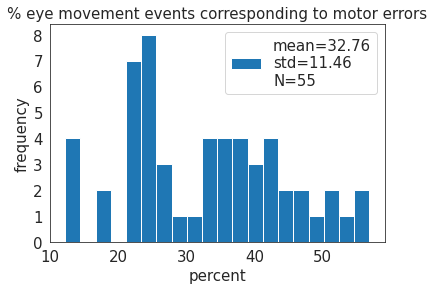

In [25]:
# show distribution of motor error events to no-motor error events
plt.figure()
plt.hist(d,bins=20,label = f'mean={np.round(np.average(d),2)}\nstd={np.round(np.std(d),2)}\nN={len(d)}')

plt.xlabel('percent',fontsize=15)
plt.ylabel('frequency',fontsize=15)
plt.title('% eye movement events corresponding to motor errors',fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Analyze blink frequencies

In [26]:
durs = {}
for row in gaze_dur_diff.groupby(['subID','task','dur(s)']).count().index:
    durs[row[0]+row[1]] = row[2]
    
blinks = {}
l = errors_.groupby(['subID','task']).count().motor_error
for i in range(len(l.index)):
    blinks[l.index[i][0]+l.index[i][1]] = l.values[i]

In [27]:
blink_freqs = {}
for k, v in blinks.items():
    try:
        blink_freqs[k] = v/durs[k]
    except:
        pass

In [28]:
blink_freqs

{'P13cereal': 0.049107921100016376,
 'P13sandwich': 0.10226599017445359,
 'P14cereal': 0.1099962468159012,
 'P14sandwich': 0.06777865545883448,
 'P15cereal': 0.10244296742842135,
 'P18cereal': 0.10214017655642024,
 'P18sandwich': 0.10671170102031263,
 'P19cereal': 0.09459140844045598,
 'P19sandwich': 0.05583433136429844,
 'P2cereal': 0.15612176143522324,
 'P2sandwich': 0.03789532367802073,
 'P21cereal': 0.057603742319508454,
 'P22cereal': 0.08409258304134548,
 'P22sandwich': 0.0639905059511113,
 'P23cereal': 0.10104601152277966,
 'P23sandwich': 0.04868931778569665,
 'P24cereal': 0.06558817009182336,
 'P24sandwich': 0.03458881129900077,
 'P25cereal': 0.033863899988712046,
 'P25sandwich': 0.05458622426985164,
 'P3cereal': 0.05545291866913124,
 'P3sandwich': 0.09693062681744749,
 'P4cereal': 0.07504697686053784,
 'P4sandwich': 0.11801206657084501,
 'P5cereal': 0.11661818853255587,
 'P5sandwich': 0.12201182313262574,
 'P6cereal': 0.09208112031921424,
 'P6sandwich': 0.046185865599261036,
 '

In [29]:
c_freq = {k:v for k,v in blink_freqs.items() if 'cereal' in k}
s_freq = {k:v for k,v in blink_freqs.items() if 'sandwich' in k}

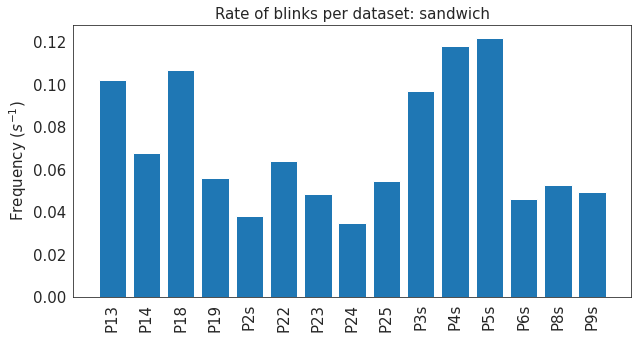

mean: 0.071, std: 0.029


In [30]:
plt.figure(figsize=(10,5))
plt.bar(range(len(s_freq.keys())), list(s_freq.values()))
k = [s[:3] for s in s_freq.keys()]
plt.xticks(range(len(s_freq.keys())), k, rotation=90,fontsize=15)
plt.title('Rate of blinks per dataset: sandwich',fontsize=15)
plt.ylabel('Frequency ($s^{-1}$)',fontsize=15)
plt.yticks(fontsize=15)
plt.show()
print(f'mean: {np.round(np.average(list(s_freq.values())),3)}, std: {np.round(np.std(list(s_freq.values())),3)}')

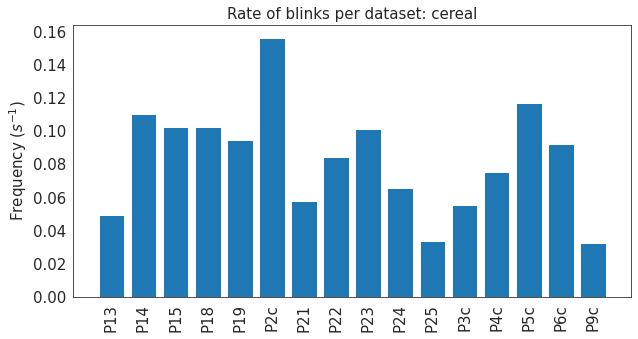

mean: 0.083, std: 0.032


In [31]:
plt.figure(figsize=(10,5))
plt.bar(range(len(c_freq.keys())), list(c_freq.values()))
k = [s[:3] for s in c_freq.keys()]
plt.xticks(range(len(c_freq.keys())), k, rotation=90, fontsize=15)
plt.title('Rate of blinks per dataset: cereal',fontsize=15)
plt.ylabel('Frequency ($s^{-1}$)',fontsize=15)
plt.yticks(fontsize=15)
plt.show()
print(f'mean: {np.round(np.average(list(c_freq.values())),3)}, std: {np.round(np.std(list(c_freq.values())),3)}')